In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

## **Deep Learning**

### Backpropagation

While the perceptron learning rule can in principle be used to train multi-layer neural networks, this approach is not attractive when we want to learn a complex unknown function with a deep neural network. In that case, we do not know each unit's correct output for a given input, which is required for successful application of the perceptron learning rule. Furthermore, it is inefficient to train each unit in a deep neural network separately. We thus need a different and more efficient approach to train neural networks. In this week's programming lab, we will explore backpropagation, a widely used algorithm for supervised training of deep neural networks.

Like the perceptron learning algorithm, backpropagation treats deep learning as an optimization problem. We first define a loss function which measures, for a single training example $x$, the mismatch between the network's output $f(x)$ and the correct output. We then use backpropagation to determine how to change the network's weights to minimize the loss. Backpropagation characterizes the sensitivity of the loss function to slight changes in the network's activations and weights given a particular training example. It does so by computing derivatives of the loss function with respect to the activations and weights (error derivatives or gradients). We start with computing error derivates for the network's output layer and propagate them back through the network using the chain rule. We then use gradient descent to adjust each weight in the direction that reduces the loss and by an amount proportional to the magnitude of the weight's gradient. We optimize the weights by repeatedly applying these steps across (batches of) training examples.

### Logistic Regression

For backpropagation to work, the neural network has to be composed of differentiable operations. We will therefore demonstrate backpropagation using logistic regression (Figure 1). Logistic regression uses a sigmoid activation function, which is differentiable, as opposed to the stepwise activation function of the perceptron. Compared to a deep neural network with many units, logistic regression is relatively simple. However, the principles of backpropagation do not depend on network depth and can thus be demonstrated well using logistic regression.

Figure $1 \mid$ Logistic regression learns a function that maps input $x$ to an output value $f(x)$ by adjusting the weights $w$ and bias $b$. Logistic regression is very similar to the perceptron, but uses a sigmoid activation function. $x$ is a real-valued vector, $f(x)$ is a single value in the range $(0,1)$.

The logistic regression function is defined by the equation:

$$
f(x)=\sigma\left(w^T x+b\right)
$$

where $x$ is the input vector, $w$ are the weights connecting the input units to the output unit, $b$ is the bias term, and $\sigma$ is the sigmoid activation function. The sigmoid activation function is:

$$
\sigma(z)=\frac{1}{1+e^{-z}}
$$

$f(x)$ lies in the range $(0,1)$ and represents the probability of a certain class or event given input $x$. Logistic regression is often used for binary classification. We compute the predicted class label by thresholding $f(x)$, e.g., values $<0.5$ are class 0 and values $\geq 0.5$ are class 1 .

### Solve logistic regression using backpropagation

We will use logistic regression to classify inputs into two categories. As in Programming Lab 9, let our categories be ripe and unripe apples. Each apple is described by two values: colour ( $x_1$ ) and size $\left(x_2\right)$. Values on the colour dimension range from green (low) to red (high). Values on the size dimension range from small (low) to large (high). Unripe apples have low values on both dimensions; ripe apples have high values on both dimensions.

Figure 2 | We will use logistic regression to classify apples as ripe or unripe. The input ( $x$ ) consists of two values, which reflect the colour $\left(x_1\right)$ and size $\left(x_1\right)$ of the apple. The correct output value $f(x)$ is $<0.5$ for unripe apples and $>=0.5$ for ripe apples.

Let's start with importing libraries and generating training data.

### Import libraries

In [2]:
# import libraries
import numpy as np
from numpy import random
import numpy.matlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from decimal import *
from IPython.display import clear_output

# high quality plotting 
plt.rcParams['figure.dpi'] = 200

### Generate training data

Text(0.5, 1.0, 'classes of apples (training data)')

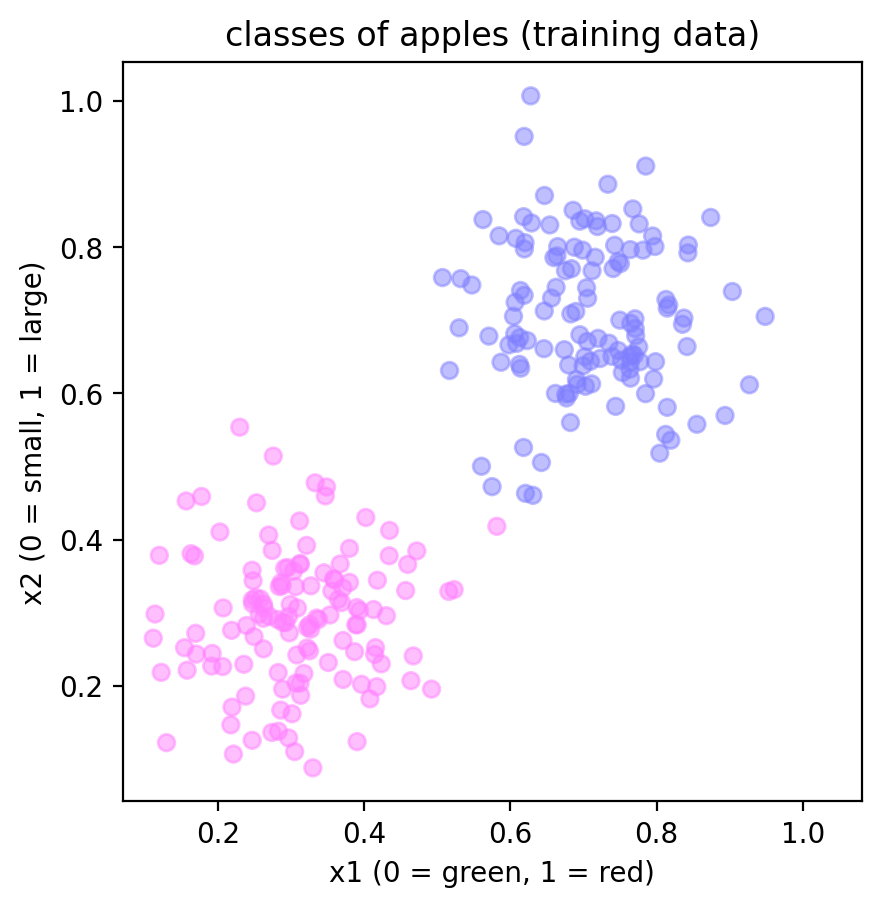

In [3]:
# generate data (inputs x and outputs f(x))
def generate_data(means, sigma, ndatapoints):
    nclasses = 2
    data = np.zeros( (nclasses * ndatapoints, 3) )
    for c in range(0, nclasses):
        starti = c * ndatapoints
        endi = (c + 1) * ndatapoints
        data[starti:endi, 0:2] = means[c] + sigma * random.standard_normal( (ndatapoints, 2) )
        data[starti:endi, 2] = c
    randvec = np.random.permutation(nclasses * ndatapoints)
    data = data[randvec,:]
    return data, randvec;

# set parameters and generate training data
means = (0.3, 0.7)
sigma = 0.09
ndatapoints = 128 # generating 128 training examples
data_output_train = generate_data(means, sigma, ndatapoints)
data_train = data_output_train[0]
randvec_train = data_output_train[1]

# show generated data
colors_train = np.concatenate( (np.matlib.repmat(np.array([1, 0.5, 1]), ndatapoints, 1), np.matlib.repmat(np.array([0.5, 0.5, 1]), ndatapoints, 1)))
colors_train = colors_train[randvec_train,:]
plt.figure(1)
plt.clf()
plt.scatter(data_train[:,0], data_train[:,1], c = colors_train, alpha = 0.5)
plt.axis('square')
plt.xlabel('x1 (0 = green, 1 = red)')
plt.ylabel('x2 (0 = small, 1 = large)')
plt.title('classes of apples (training data)')

### Define activation function and initialize weights

Next, we define our activation function and initialize the weights. For logistic regression, we initialize all weights to zero. Next week, we will discuss how to initialize weights for larger neural networks.

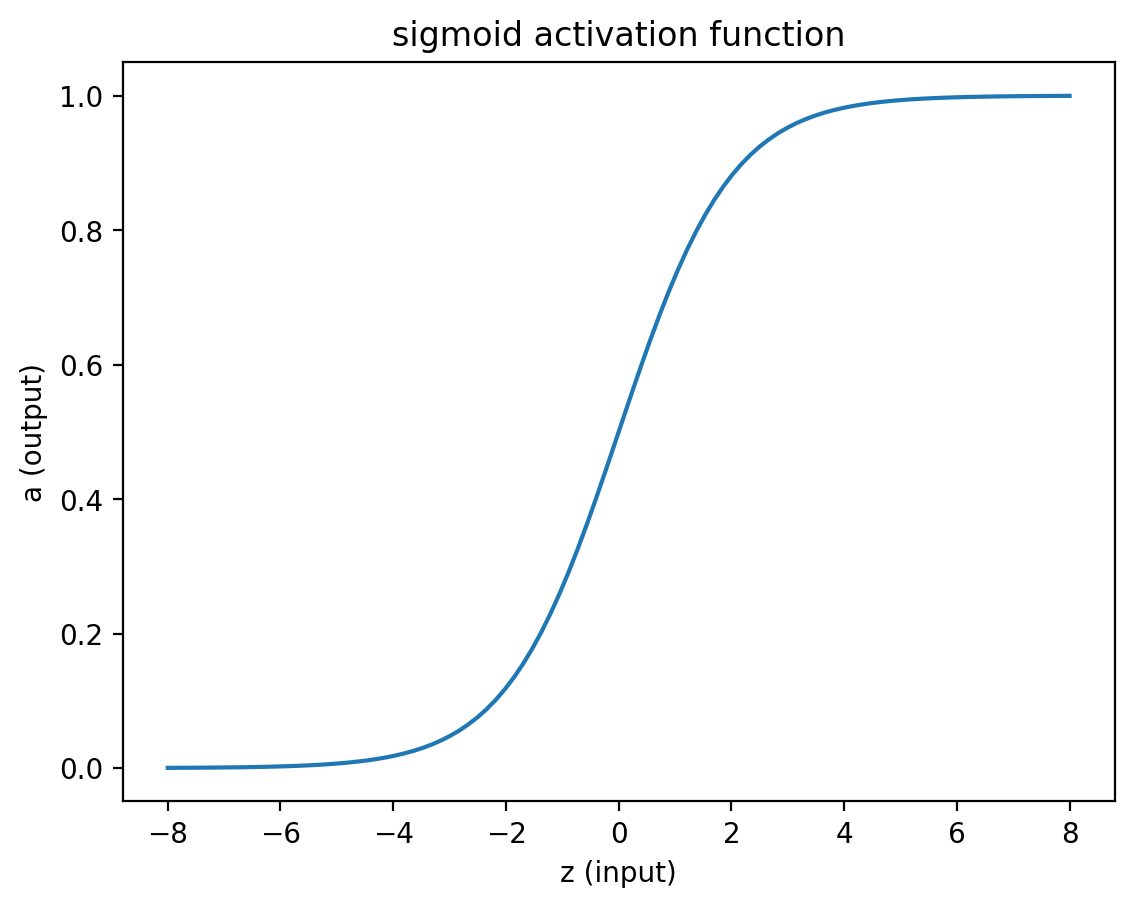

In [4]:
# sigmoid activation function
def sigmoid(z):
    a = 1 / (1 + np.exp(-z))
    return a

# show the sigmoid function
z = np.linspace(-8, 8, 100)
a = sigmoid(z)
plt.figure(2)
plt.clf()
plt.plot(z, a)
plt.xlabel('z (input)')
plt.ylabel('a (output)')
plt.title('sigmoid activation function')

# initialize weights
def initialize_weights(nweights, randn):
    if randn == 0:
        w = np.zeros( (nweights, 1) )
    else:
        w = 0.001 * random.standard_normal( (nweights, 1) )
    b = 0
    return w, b

nweights = 2
randn = 0
w, b = initialize_weights(nweights, randn) # for now, set the weights and bias to zero 

### Propagate activation forward and compute the cost

Let's now propagate activation forward, i.e. compute $f(x)$ for our training data $X$ using the initialized weights. $X$ is a matrix of size ( n input units, n training examples). $f(x)$ will thus be a vector of outputs with as many entries as training examples.

We will also compute the cost, i.e. the average loss across training examples. We use the negative log-likelihood for logistic regression as our loss function. This function is also known as the binary cross-entropy loss function. The cost function, which averages the loss across training examples, is defined as:

$$
J=-\frac{1}{m} \sum_{i=1}^m[y \log (a)+(1-y) \log (1-a)]
$$

where $J$ is the cost, $m$ is the number of training examples, $y$ is the correct output, and $a$ is the predicted output, i.e., $f(x)$.

Text(0.5, 1.0, 'cost function')

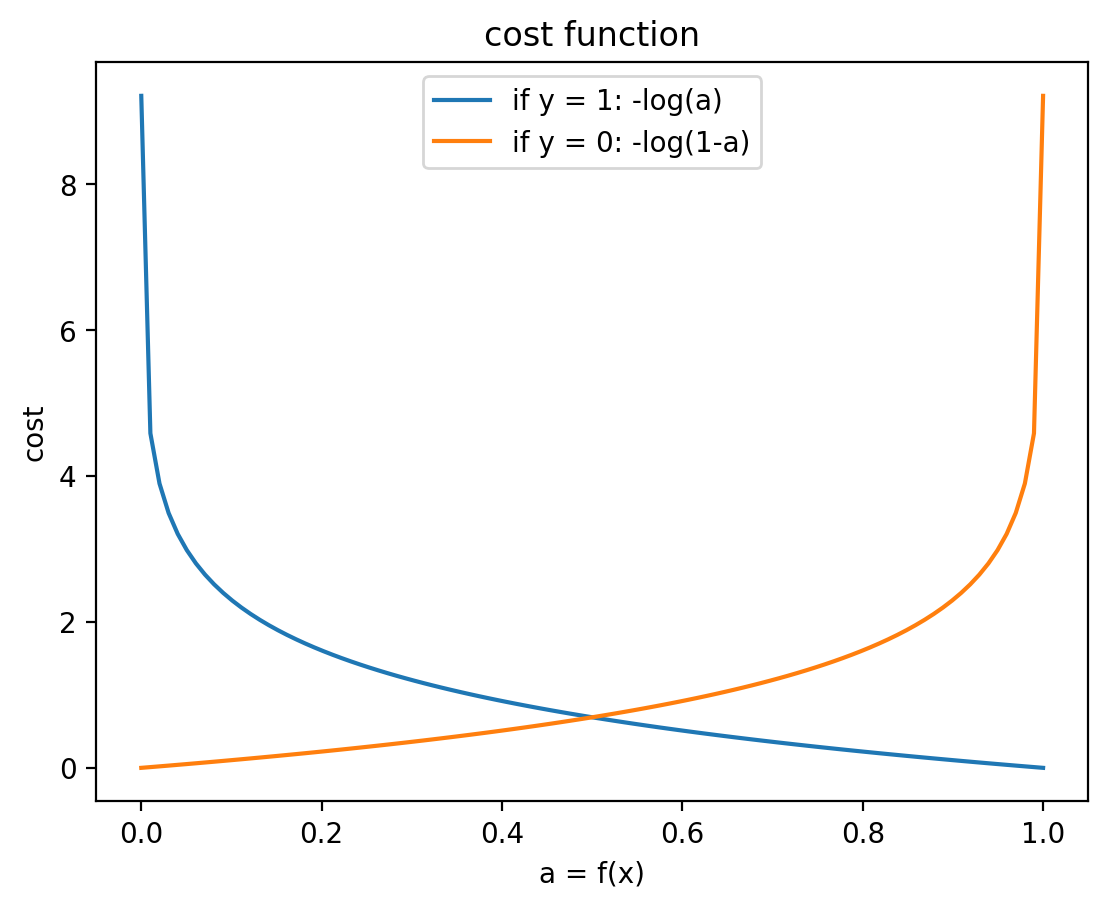

In [5]:
# propagate forward
def forward(X, w, b):
    z = np.dot(np.transpose(w), X) + b
    a = sigmoid(z)
    return a

X = np.transpose( data_train[:,0:2] )
a = forward(X, w, b)                    # perform one forward pass (w and b will all be zero)

# compute cost
def compute_cost(a, y):
    m = a.shape[1] # number of training samples
    cost =  -(1 / m) * np.sum(y * np.log(a) + (1 - y) * np.log(1 - a))
    return cost

y = np.transpose( data_train[:,2:3] ) # true/expected outputs
cost = compute_cost(a, y)             # compute cost 

# show cost function
a_ls = np.linspace(0.0001, 0.9999, 100)
cost_y1 = - np.log(a_ls)
cost_y0 = - np.log(1 - a_ls)
plt.figure(3)
plt.clf()
plt.plot(a_ls, cost_y1)
plt.plot(a_ls, cost_y0)
plt.legend( ('if y = 1: -log(a)', 'if y = 0: -log(1-a)') )
plt.xlabel('a = f(x)')
plt.ylabel('cost')
plt.title('cost function')

**Blue line:** $y=1$ so we want $a=1$ where the cost is minimized. 

**Orange Line:** $y=0$ so we want $a=0$ where the cost is minimized. 

Note that the cost behaves as we would expect. Note that the addition of these two is a convex surface $\implies$ there is a global minimum.

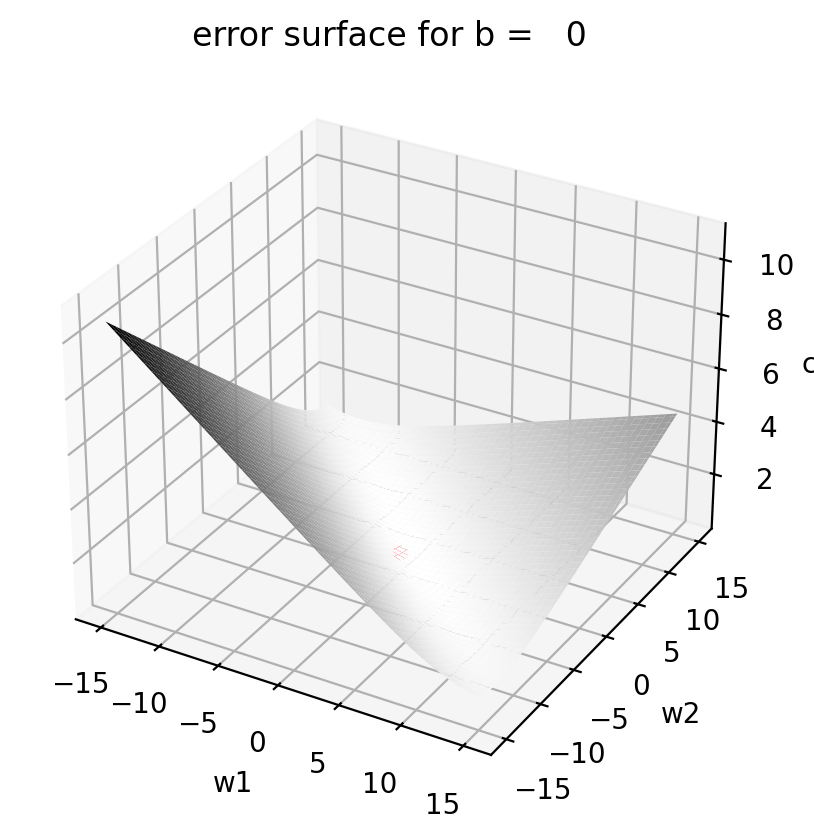

In [6]:
# show error surface
def error_surface(b, w, cost):
    # compute error surface across w1 and w2 for a user-identified value of b (input arg b)
    w1 = np.linspace(-15, 15, 100)
    w2 = np.linspace(-15, 15, 100)
    xx, yy = np.meshgrid(w1, w2)

    costs = np.zeros( (w1.shape[0], w2.shape[0]) )
    
    for r in range(w1.shape[0]):
        for c in range(w2.shape[0]):
            cw = np.zeros( (nweights, 1) )
            cw[0] = xx[r,c]
            cw[1] = yy[r,c]
            ca = forward(X, cw, b)
            ccost = compute_cost(ca, y)
            costs[r,c] = ccost

    # clear previous plot but keep the latest (ensure we don't create a new figure each time)
    clear_output(wait=True)

    # plot error surface
    plt.figure(1)
    plt.clf()
    ax = plt.axes(projection = '3d')
    ax.plot_surface(xx, yy, costs, cmap = 'binary', edgecolor = 'none')
    ax.scatter(w[0], w[1], cost, c = 'r') # plot cost for current weights (input args b and w)

    # add figure labels
    width = 3
    precision = 3
    value = Decimal(b)
    title = f"error surface for b = {value:{width}.{precision}}"
    ax.set_title(title)
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_zlabel('cost')
    plt.show()
    plt.pause(0.004)

    return xx, yy, costs

xx, yy, costs = error_surface(b, w, cost)

There was an initial worry that we may "get stuck" in higher dimensional cost functions (mountain-scape) where there may be many local minima. However, this doesn't end up being an issue because of the increased number of degrees of freedom -> we can move around "quickly" to find minima and choose the lowest one.

Can also use "momentum" -> take into account where you come from so you're not swayed off the path by some noisy step. This results in some nice "smoothness" in finding the minimum.

### Backpropagation

The next step is backpropagation. To understand backpropagation, it is helpful to express a neural network as a computational graph. A computational graph expresses a model as a directed graph where nodes correspond to operations and edges to inputs. Figure 3 expresses our simple logistic regression neural network as a computational graph.

Figure 3 | Computational graph for logistic regression. Black arrows reflect forward propagation of activation, coloured arrows reflect backpropagation of error derivatives. The error derivatives, which are partial derivatives of the cost function $J$ with respect to the activations and weights, are shown below the graph. The blue error derivatives characterize the sensitivity of the cost for a slight change in $w$ and $b$ given a particular training example $x$.

We will compute the error derivatives of the cost function $J$ with respect to weights $w$ and bias term $b$ as follows:

$$
\begin{aligned}
& \frac{\partial J}{\partial w}=\frac{1}{m} X(a-y)^T \\
& \frac{\partial J}{\partial b}=\frac{1}{m} \sum_{i=1}^m(a-y)
\end{aligned}
$$

where $\partial$ indicates the partial derivative, $J$ is the cost function, $m$ is the number of training examples, $X$ are the training examples, $y$ is the correct output, and $a$ is the predicted output. The error derivatives are computed for each individual training example in the batch and then averaged.

In [7]:
# propagate back
def back(a, y, X):
    m = a.shape[1]
    dw = (1 / m) * np.dot(X, np.transpose(a - y))
    db = (1 / m) * np.sum(a - y)
    return dw, db

dw, db = back(a, y, X)

In [8]:
print(dw) # get a error slope value for each weight
print(db) # get a error slope value for the bias

[[-0.0996858 ]
 [-0.10261315]]
0.0


### Gradient descent

Now we can optimize the weights using gradient descent. The error gradients tell us in which direction and how much to adjust the weights to reduce the cost. We iteratively adjust the weights until convergence on a global or local minimum. If the cost function is convex, as for logistic regression, we will converge on a global minimum independent of where we start in weight space. On each iteration, we update the weights as follows:

$$
\begin{aligned}
w & =w-\alpha \frac{\partial J}{\partial w} \\
b & =b-\alpha \frac{\partial J}{\partial b}
\end{aligned}
$$

where $\alpha$ is the learning rate. The learning rate is usually a small positive value in the range ( 0,1 ), which controls how much to update the weights in response to the estimated error. A small learning rate is associated with slow learning but smooth convergence. A large learning rate speeds up learning, but learning may not converge.

In [9]:
# plot the decision boundary (as in lab 9)
def plot_boundary(weights, data, colors):
    b = weights['b']
    w = weights['w']
    slope = -(b / w[1]) / (b / w[0])
    y_intercept = -b / w[1]
    x = np.linspace(0,1,100)
    y = (slope * x) + y_intercept

    # clear previous plot but keep the latest (ensure we don't create a new figure each time)
    clear_output(wait=True)

    # replot training data
    plt.figure(1)
    plt.clf()
    plt.scatter(data[:,0], data[:,1], c = colors, alpha = 0.5)
    plt.axis('square')
    plt.xlabel('x1 (0 = green, 1 = red)')
    plt.ylabel('x2 (0 = small, 1 = large)')
    plt.title('classes of apples (training data)')

    # plot boundary
    plt.plot(x, y)
    plt.pause(0.004)

# optimize weights using gradient descent
def optimize(w, b, X, y, niterations, alpha, monitor):

    costs = []

    for i in range(niterations):

        # forward pass
        a = forward(X, w, b)
        cost = compute_cost(a, y)

        # backpropagation
        dw, db = back(a, y, X)

        # update weights
        w = w - alpha * dw
        b = b - alpha * db

        # cost tracking
        costs.append(cost)

	    # plot decision boundary (for first 100 iterations and last iteration)
        # only do this for the first 100 iterations because that's where the largest changes are
        if monitor and (i <= 100 or i == niterations-1):
            cweights = {"w": w,
                       "b": b}
            plot_boundary(cweights, data_train, colors_train)

	    # print cost and show error surface (incl. cost) for every 100 iterations
        if monitor and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            error_surface(b, w, cost)

    # save and return weights, gradients, and costs
    weights = {"w": w,
              "b": b}

    gradients = {"dw": dw,
                "db": db}

    return weights, gradients, costs

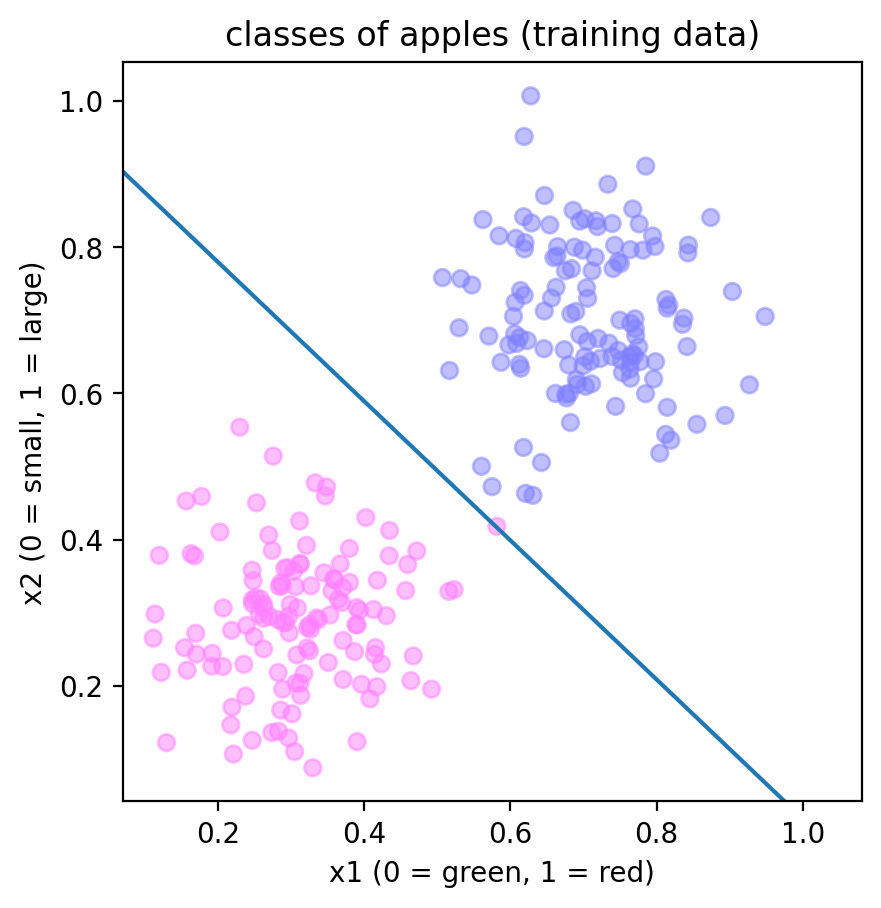

Text(0.5, 1.0, 'minimizing cost through gradient descent')

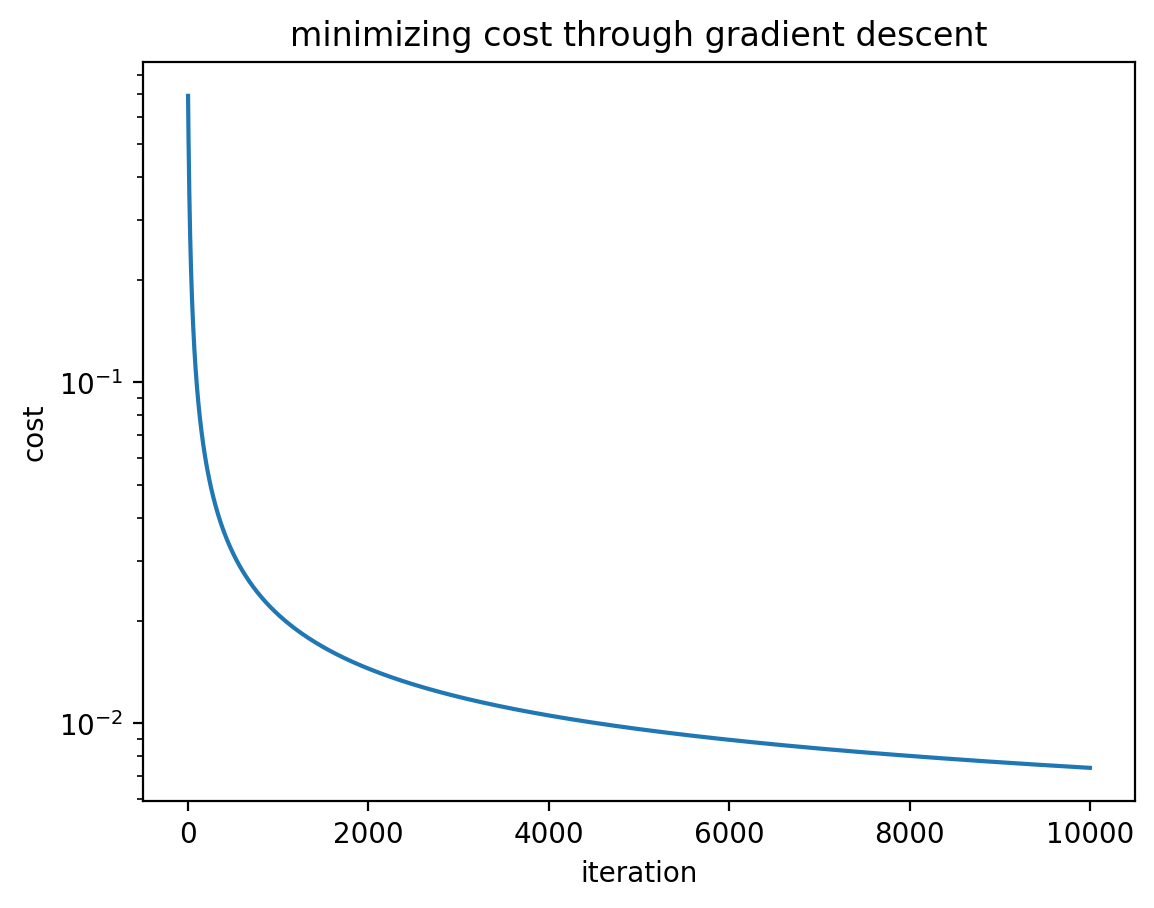

In [10]:
niterations = 10000
alpha = 3.0
monitor = 1
weights, gradients, costs = optimize(w, b, X, y, niterations, alpha, monitor)

# plot cost as a function of iteration
plt.figure(5)
plt.clf()
plt.plot(costs)
plt.xlabel('iteration')
plt.ylabel('cost')
plt.yscale('log')
plt.title('minimizing cost through gradient descent')

Note that the cost is minimized but **not** zero (this was the case in the perceptron) because all of the data is taken into account. (we will discuss this in more detail later)

It may also be due to the fact that the boundary is correct after we bianize the data but the output from the sigmoid function is not exactly 0 or 1 for any of the data points. So we get the correct prediction (in the training set) but the cost is not perfecly zero.

The decision boundary is also not perfectly between the two classes. There could be some class imbalance that causes this in some cases but this is not the case here.

### Test performance

Finally, we want to test performance of our logistic regression model on new data. Let's generate test data and determine how well the model performs at classifying the 'test apples' as ripe or unripe.

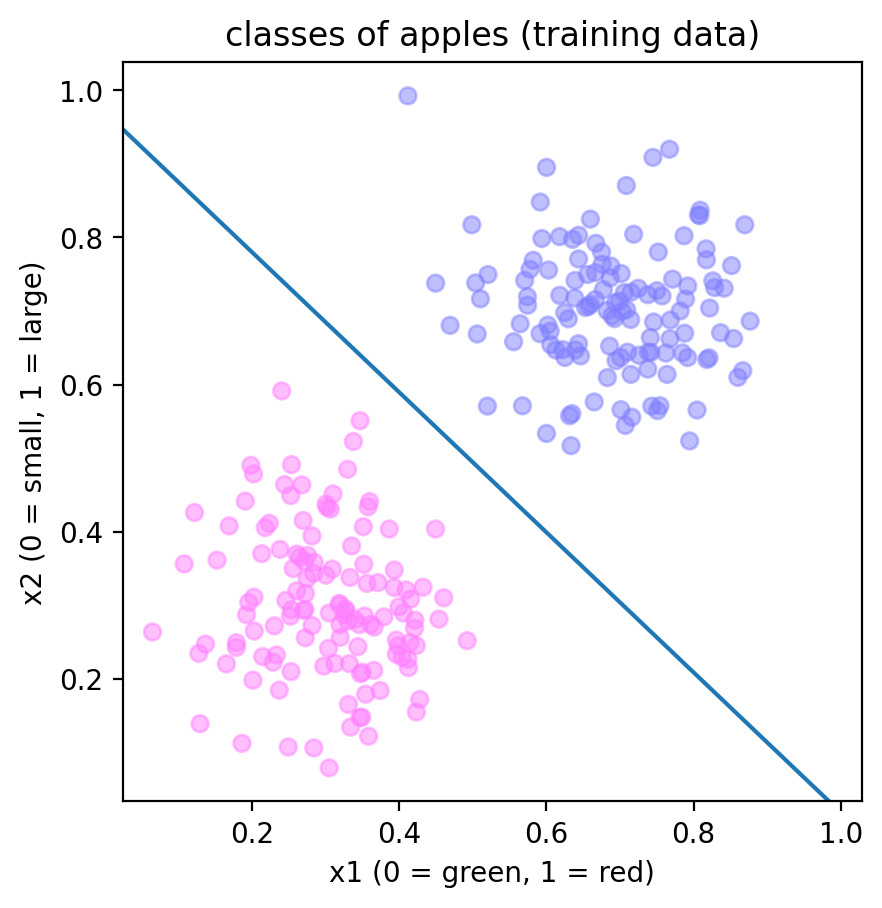

test accuracy: 100.0 %


In [13]:
# generate test data
means = (0.3,0.7)
sigma = 0.09
ndatapoints = 128
data_output_test = generate_data(means, sigma, ndatapoints)
data_test = data_output_test[0]
randvec_test = data_output_test[1]

# show generated data and learned decision boundary
colors_test = np.concatenate( (np.matlib.repmat(np.array([1, 0.5, 1]), ndatapoints, 1), np.matlib.repmat(np.array([0.5, 0.5, 1]), ndatapoints, 1)))
colors_test = colors_test[randvec_test,:]
plt.figure(1)
plt.clf()
plt.scatter(data_test[:,0], data_test[:,1], c = colors_test, alpha = 0.5)
plt.axis('square')
plt.xlabel('x1 (0 = green, 1 = red)')
plt.ylabel('x2 (0 = small, 1 = large)')
plt.title('classes of apples (test data)')
plot_boundary(weights, data_test, colors_test)

# compute class predictions
def predict(data, weights):
    X = np.transpose( data[:,0:2] )
    y = np.transpose(data[:,2:3])

    a = forward(X, weights['w'], weights['b'])
    p = np.zeros(a.shape)
    for i in range(a.shape[1]):
        if a[0,i] < 0.5:
            p[0,i] = 0
        else:
            p[0,i] = 1

    return p

y_test = np.transpose(data_test[:,2:3])
p_test = predict(data_test, weights)

# now p_test and y_test are both 0s and 1s
print("test accuracy: {} %".format(100 - np.mean(np.abs(p_test - y_test)) * 100))